# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/11smwsjvC9B4W5Kr5O-6dAEpEd4Ri2u5b?usp=sharing

As we are using the older version of the torchtext, please run the following to downgrade the torchtext version:


!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [1]:
 !pip install torchtext==0.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 408.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

If you are interested to use the most recent version if torchtext, you can look at the following document to see how to convert the legacy version to the new version:
https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [4]:
done = 0
for line in open('SMSSpamCollection'):
  if done == 0:
    if line[0] == 'h':
      print(line)
      done = 1
  if done == 1:
    if line[0] == 's':
      print(line)
      done = 2

#The label for a spam message is 'spam' and the label for a non-spam message is 'ham'

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [5]:
spam = 0
nonspam = 0
for line in open('SMSSpamCollection'):
  if line[0] == 'h':
    nonspam += 1
  if line[0] == 's':
    spam += 1
print(spam)
print(nonspam)
#There are 747 spam messages and 4827 nonspam messages

747
4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

In [6]:
#Advantage: SMS text messages usually use short words and informal language such
#as abbreviations. Therefore, character-level models are better since they are
#able to capture the nuances more effectively compared to word-level models
#which would struggle with the slang and weird words.
#Advantage: Character-level models are better for misspellings and typos that
#usually occur in text messages. Since each character is treated individually
#not each word, the model can learn patterns even when characters are misspelled.
#Disadvantage: It takes more time and is more complex since there are more nodes
#in the input sequence. This leads to higher computation costs and longer training
#times.
#Disadvantage: Its harder to understand the meaning of the words since each
#character is treated differently. This can lead to less accurate predictions
#especially when understanding the word is crutial.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file.

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file.
In our case, the dataset has two fields:

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [7]:
import torchtext

text_field = torchtext.data.Field(
    sequential= True, #sequences needed for worsd
    tokenize= lambda x: x, #character RNN
    include_lengths= True, #track length of sequences
    batch_first= True, #batch_size first
    use_vocab= True) #turn character to integer

label_field = torchtext.data.Field(
    sequential= False, #sequence doesnt matter
    batch_first= True, #batch_size first
    use_vocab= False, #no need to track vocab
    is_target= True, #target field for labels
    preprocessing= lambda x: int(x == 'spam')) #convert to 1 or 0

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset("SMSSpamCollection",
                                        "tsv",               #seperate using tab
                                        fields)

train, val, test = dataset.split([0.6, 0.2, 0.2])

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [8]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

#if there are more non-spam messages, the model will just label all datas 'ham'
#and this would result in a high accuracy even tho the model isnt learning anything.
#Therefore we need a balanced training set to train the model accuratly.

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [9]:
text_field.build_vocab(train)
print(text_field.vocab.stoi) #mapping characters to their numerical identifiers
print('\n')
print(text_field.vocab.itos) #list of characters indexed by their numerical identifiers

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7fae85140f70>>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, '0': 14, '.': 15, 'd': 16, 'c': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, '2': 25, 'b': 26, 'T': 27, '8': 28, 'k': 29, 'E': 30, 'v': 31, '5': 32, 'S': 33, 'C': 34, 'O': 35, 'I': 36, '7': 37, 'A': 38, '4': 39, 'N': 40, 'x': 41, '6': 42, '3': 43, 'R': 44, '!': 45, ',': 46, '9': 47, 'P': 48, 'M': 49, 'U': 50, 'W': 51, 'L': 52, 'H': 53, 'D': 54, 'B': 55, 'Y': 56, 'G': 57, 'F': 58, '/': 59, '?': 60, "'": 61, '£': 62, '&': 63, '-': 64, ':': 65, 'X': 66, 'z': 67, 'V': 68, 'j': 69, '*': 70, 'K': 71, ')': 72, 'J': 73, ';': 74, '+': 75, '(': 76, 'Q': 77, 'q': 78, '#': 79, '"': 80, '@': 81, '=': 82, 'Z': 83, 'ü': 84, '>': 85, '$': 86, 'Ü': 87, '%': 88, '|': 89, '[': 90, ']': 91, '\x92': 92, '‘': 93, '_': 94, '<': 95, '¡': 96, '“': 97, '\x93': 98,

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

In [10]:
# <unk> represents unknown tokens
# <pad> represents padding, it is added to make sure all sequences of characters
# have the same length

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [11]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [12]:
count= 0
for batch in train_iter:
    if count== 10:
      break
    else:
      print("Batch number:", count + 1, "Max length:", int(batch.sms[1][0]))
      # batch.sms[1] contains 32 elements in decending order representing the actual
      # length of each message. batch.sms[0] contains the after-padding tensors.
      sum= 0
      for message in range(0, len(batch.sms[1])):
        sum = sum + batch.sms[1][0] - batch.sms[1][message]
        # sum of max length - actual length is the amount of paddings
      print("Number of <pad> used:", int(sum))
      count += 1

Batch number: 1 Max length: 156
Number of <pad> used: 0
Batch number: 2 Max length: 33
Number of <pad> used: 30
Batch number: 3 Max length: 65
Number of <pad> used: 47
Batch number: 4 Max length: 155
Number of <pad> used: 26
Batch number: 5 Max length: 41
Number of <pad> used: 19
Batch number: 6 Max length: 112
Number of <pad> used: 62
Batch number: 7 Max length: 153
Number of <pad> used: 0
Batch number: 8 Max length: 152
Number of <pad> used: 0
Batch number: 9 Max length: 130
Number of <pad> used: 24
Batch number: 10 Max length: 158
Number of <pad> used: 30


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing.
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [13]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [23]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN, self).__init__()
        self.emb = torch.eye(len(text_field.vocab.itos))
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Look up the embedding
        x = self.emb[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [15]:
def get_accuracy(model, data_loader):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    correct, total = 0, 0
    for batch in data_loader:
        sms = batch.sms
        label = batch.label
        output = model(sms[0])
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(label.view_as(pred)).sum().item()
        total += label.shape[0]
    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

In [16]:
import matplotlib.pyplot as plt

In [35]:
def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for batch in train:
            sms = batch.sms
            label = batch.label
            optimizer.zero_grad()
            pred = model(sms[0])
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train))
        valid_acc.append(get_accuracy(model, valid))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
        model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format("RNN", 32, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [18]:
valid_iter = torchtext.data.BucketIterator(val,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [19]:
len(text_field.vocab)

110

Epoch 1; Loss 0.718037; Train Acc 0.520344; Val Acc 0.142601
Epoch 2; Loss 0.719155; Train Acc 0.525693; Val Acc 0.147982
Epoch 3; Loss 0.698888; Train Acc 0.538337; Val Acc 0.151570
Epoch 4; Loss 0.730435; Train Acc 0.542227; Val Acc 0.158744
Epoch 5; Loss 0.687361; Train Acc 0.546604; Val Acc 0.175785
Epoch 6; Loss 0.709158; Train Acc 0.560058; Val Acc 0.184753
Epoch 7; Loss 0.633130; Train Acc 0.592316; Val Acc 0.274439
Epoch 8; Loss 0.625935; Train Acc 0.623440; Val Acc 0.377578
Epoch 9; Loss 0.610853; Train Acc 0.668018; Val Acc 0.547085
Epoch 10; Loss 0.649159; Train Acc 0.684552; Val Acc 0.617040


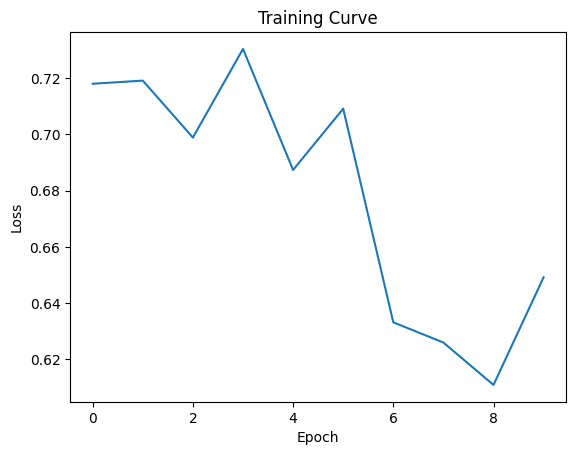

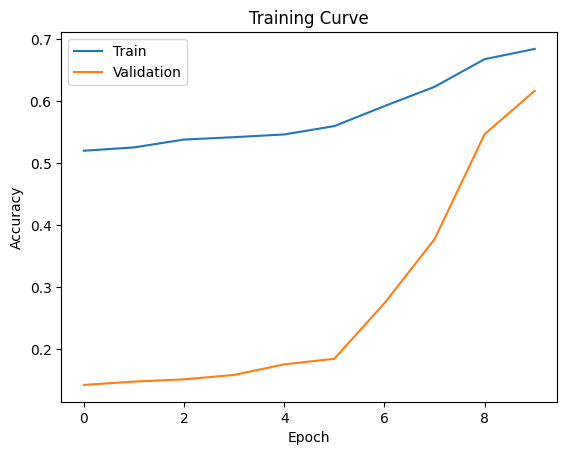

In [36]:
model = RNN(110, 110, 2)
train_rnn_network(model, train_iter, valid_iter, num_epochs = 10)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

In [29]:
#model = RNN(110, 110, 2)
#train_rnn_network(model, train_iter, valid_iter, learning_rate = 0.0001, num_epochs = 10)

In [30]:
#model = RNN(110, 110, 2)
#train_rnn_network(model, train_iter, valid_iter, num_epochs = 20)

In [26]:
#model = RNN(110, 75, 2)
#train_rnn_network(model, train_iter, valid_iter, num_epochs = 10)

In [31]:
class RNN_s(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN_s, self).__init__()
        self.emb = torch.eye(len(text_field.vocab.itos))
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size*num_classes, num_classes)

    def forward(self, x):
        # Look up the embedding
        x = self.emb[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
        return self.fc(out)

#model = RNN_s(110, 110, 2)
#train_rnn_network(model, train_iter, valid_iter, learning_rate= 0.0001, num_epochs = 10)

In [32]:
# Increasing the learning rate from 0.00001 to 0.0001 caused the final validation
# accuracy to increase from 68% to 95%.
# Increasing the number of epochs from 10 to 20 caused the final validation accuracy
# to increase from 68% to 91.6%.
# Decreasing the hidden size of the RNN from 110 to 75 caused the final validation
# accuracy to decrease from 68% to 19.9%
# Changing the model to using max pooling and average pooling caused the final
# validation accuracy to increase from 68% to 96.9%

# For the final model I decided to increase the learning rate to 0.0001,
# increase the number of epochs to 20, keep the hidden size to 114
# and change the model architecure since it gives the greatest accuracy of 98%.

Epoch 1; Loss 0.613608; Train Acc 0.535905; Val Acc 0.133632
Epoch 2; Loss 0.765871; Train Acc 0.872265; Val Acc 0.786547
Epoch 3; Loss 0.535414; Train Acc 0.940185; Val Acc 0.938117
Epoch 4; Loss 0.436432; Train Acc 0.929162; Val Acc 0.934529
Epoch 5; Loss 0.204855; Train Acc 0.950073; Val Acc 0.943498
Epoch 6; Loss 0.165575; Train Acc 0.959637; Val Acc 0.940807
Epoch 7; Loss 0.238771; Train Acc 0.949425; Val Acc 0.901345
Epoch 8; Loss 0.078664; Train Acc 0.956071; Val Acc 0.966816
Epoch 9; Loss 0.077219; Train Acc 0.967580; Val Acc 0.952466
Epoch 10; Loss 0.063514; Train Acc 0.966931; Val Acc 0.963229
Epoch 11; Loss 0.050151; Train Acc 0.961744; Val Acc 0.970404
Epoch 12; Loss 0.211938; Train Acc 0.960934; Val Acc 0.940807
Epoch 13; Loss 0.070829; Train Acc 0.971470; Val Acc 0.956054
Epoch 14; Loss 0.022357; Train Acc 0.967742; Val Acc 0.972197
Epoch 15; Loss 0.045529; Train Acc 0.967742; Val Acc 0.944395
Epoch 16; Loss 0.448517; Train Acc 0.972929; Val Acc 0.965919
Epoch 17; Loss 0.

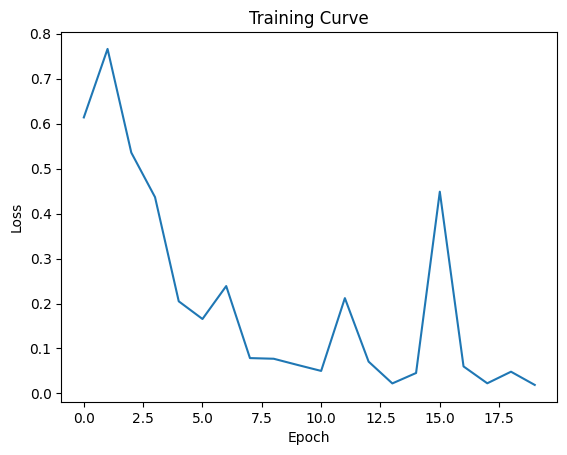

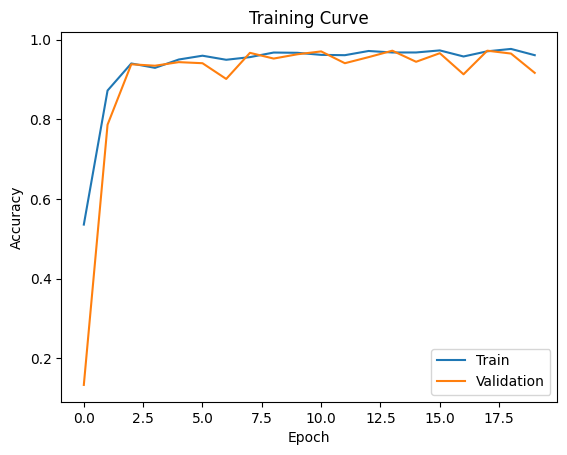

In [37]:
model = RNN_s(110, 110, 2)
train_rnn_network(model, train_iter, valid_iter, learning_rate= 0.0001, num_epochs = 20)

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [55]:
# dataset of spam val
valid_spam = torchtext.data.Dataset(
    [e for e in val.examples if e.label == 1],
    val.fields)
# dataset of nonspam val
valid_nospam = torchtext.data.Dataset(
    [e for e in val.examples if e.label == 0],
    val.fields)

valid_spam_iter = torchtext.data.BucketIterator(valid_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

valid_nospam_iter = torchtext.data.BucketIterator(valid_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

false_positive = 1 - get_accuracy(model, valid_nospam_iter)
false_negative = 1 - get_accuracy(model, valid_spam_iter)

print("False Positive Rate:", false_positive)
print("False Negative Rate:", false_negative)

False Positive Rate: 0.09062821833161694
False Negative Rate: 0.02777777777777779


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

In [52]:
# A false positive would mean that a message that isn't spam is labelled as spam
# and false negative means that a message that is spam is labelled as non-spam.
# The impact of a false negative would just be annoying since the user will be getting
# spam message. The impact of a false positive would be worse since it could cause
# the user to miss important messages that have been wrongly classified as spam.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [56]:
test_iter = torchtext.data.BucketIterator(test,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
acc = get_accuracy(model, test_iter)
print("Test Accuracy:", acc)

Test Accuracy: 0.9326750448833034


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [57]:
# dataset of spam test
test_spam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)
# dataset of nonspam test
test_nospam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

test_spam_iter = torchtext.data.BucketIterator(test_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

test_nospam_iter = torchtext.data.BucketIterator(test_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

false_positive = 1 - get_accuracy(model, test_nospam_iter)
false_negative = 1 - get_accuracy(model, test_spam_iter)

print("False Positive Rate:", false_positive)
print("False Negative Rate:", false_negative)

False Positive Rate: 0.07637474541751532
False Negative Rate: 0.022727272727272707


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [60]:
msg = "machine learning is sooo cool!"
msg_stoi = []
for char in range(len(msg)):
    msg_stoi.append(text_field.vocab.stoi[msg[char]])

testmsg = torch.LongTensor(msg_stoi).unsqueeze(0)
prediction = model(testmsg)
probability = F.softmax(prediction, dim=1)
print("Probability of the message being spam:", float(probability[0][1]))

Probability of the message being spam: 0.0857076495885849


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

In [61]:
#I think detecting spam can be easy and difficult depending on the
#complexity of the spam messages. The classification for the spam
#messages given to us was easy since it could be done with a simple
#RNN that was able to train quickly without much computational expense.
#However, this model is better at detecting spam than non-spam
#shown by the higher false positive than false negative. This is bad
#since we want the false positive percentage to be lower.
#A simple baseline model could be made using an algorithim that detects
#certain phrases or specific keywords that are indication of spam, it
#could also detect if a message uses 2 or more hyperlinks or extenssive
#punctuation marks or uppercase letters at weird places. This algorithim
#might not be as accurate as the RNN and might need to adapted depending
#on various training datasets.

In [62]:
%%shell
jupyter nbconvert --to html "/content/Lab5_Spam_Detection.ipynb"

[NbConvertApp] Converting notebook /content/Lab5_Spam_Detection.ipynb to html
[NbConvertApp] Writing 819499 bytes to /content/Lab5_Spam_Detection.html
